# Phase 1: Data Exploration & Cleaning

## Overview
This notebook performs the initial data preparation for the semantic book recommender. We'll download the dataset, explore its structure, identify data quality issues, and clean the data to prepare it for vector embeddings and classification tasks.

## Objectives
1. **Download Dataset**: Retrieve the 7k books dataset from Kaggle
2. **Initial Exploration**: Understand the data structure, columns, and basic statistics
3. **Missing Value Analysis**: Identify patterns in missing data and check for bias
4. **Data Cleaning**: 
   - Remove books with missing critical fields (description, ratings, pages, year)
   - Filter out books with descriptions shorter than 25 words
5. **Feature Engineering**: 
   - Create `title_and_subtitle` field (combines title and subtitle with colon separator)
   - Create `tag_description` field (prepends ISBN to description for vector DB linking)
6. **Export**: Save cleaned dataset for use in subsequent notebooks

## Expected Output
- **Cleaned Dataset**: `data/books_cleaned.csv`
- **Final Count**: ~5,000+ books (after filtering)
- **Quality**: No missing descriptions, all descriptions ≥25 words, engineered features included


## Step 1: Import Dependencies and Setup File Paths

In this cell, we'll import all necessary libraries for data manipulation, visualization, and dataset downloading. We'll also set up the data directory structure to store our cleaned datasets.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import kagglehub

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up data directory path
DATA_DIR = Path('../data')
DATA_DIR.mkdir(exist_ok=True)  # Creates directory if it doesn't exist

print("✓ Libraries imported")
print(f"✓ Data directory ready: {DATA_DIR.absolute()}")

✓ Libraries imported
✓ Data directory ready: /Users/satkarkarki/Desktop/usd/past/Learning/book-recommender-project/llm-semantic-book-recommender/notebooks/../data


/Users/satkarkarki/Desktop/usd/past/Learning/book-recommender-project/llm-semantic-book-recommender/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Step 2: Download Dataset from KaggleHub and Load into Pandas

Load the books dataset into a pandas DataFrame for analysis.


In [4]:
import kagglehub

# Download the 7k books dataset from Kaggle
print("Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print(f"✓ Dataset downloaded successfully!")
print(f"✓ Dataset location: {dataset_path}")
print(f"✓ Files available: {list(Path(dataset_path).glob('*'))}")

100%|██████████| 1.47M/1.47M [00:00<00:00, 4.23MB/s]

Extracting files...
✓ Dataset downloaded successfully!
✓ Dataset location: /Users/satkarkarki/.cache/kagglehub/datasets/dylanjcastillo/7k-books-with-metadata/versions/3
✓ Files available: [PosixPath('/Users/satkarkarki/.cache/kagglehub/datasets/dylanjcastillo/7k-books-with-metadata/versions/3/books.csv')]


In [7]:
# read the dataset
books = pd.read_csv(f"{dataset_path}/books.csv")
books.head()


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


## Step 4: Data Exploration

In [8]:

# 1. Basic Dataset Information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {books.shape[0]} rows × {books.shape[1]} columns")
print(f"\nColumn names: {list(books.columns)}")
print(f"\nData types:\n{books.dtypes}")

DATASET OVERVIEW
Shape: 6810 rows × 12 columns

Column names: ['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories', 'thumbnail', 'description', 'published_year', 'average_rating', 'num_pages', 'ratings_count']

Data types:
isbn13              int64
isbn10             object
title              object
subtitle           object
authors            object
categories         object
thumbnail          object
description        object
published_year    float64
average_rating    float64
num_pages         float64
ratings_count     float64
dtype: object


In [9]:
# 2. Display First Few Rows
books.head(10)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0
6,9780006353287,0006353282,An Autobiography,NaN,Agatha Christie,"Authors, English",http://books.google.com/books/content?id=c49GQ...,Donation.,1977.0,4.27,560.0,3975.0
7,9780006380832,0006380832,Empires of the Monsoon,A History of the Indian Ocean and Its Invaders,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0
8,9780006470229,000647022X,The Gap Into Madness,Chaos and Order,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0
9,9780006472612,0006472613,Master of the Game,NaN,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0


### Dataset Overview
- **6,810 books** with 12 columns covering identifiers, metadata, descriptions, and ratings
- All ISBNs are unique, confirming data integrity for identifier-based operations

In [10]:
# 3. Missing Values Summary
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
missing_summary = pd.DataFrame({
    'Missing Count': books.isnull().sum(),
    'Missing Percentage': (books.isnull().sum() / len(books) * 100).round(2),
    'Non-Missing Count': books.notna().sum()
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_summary)
print(f"\nTotal rows with any missing data: {books.isnull().any(axis=1).sum()}")

MISSING VALUES ANALYSIS
                Missing Count  Missing Percentage  Non-Missing Count
subtitle                 4429               65.04               2381
thumbnail                 329                4.83               6481
description               262                3.85               6548
categories                 99                1.45               6711
authors                    72                1.06               6738
average_rating             43                0.63               6767
num_pages                  43                0.63               6767
ratings_count              43                0.63               6767
published_year              6                0.09               6804

Total rows with any missing data: 4628


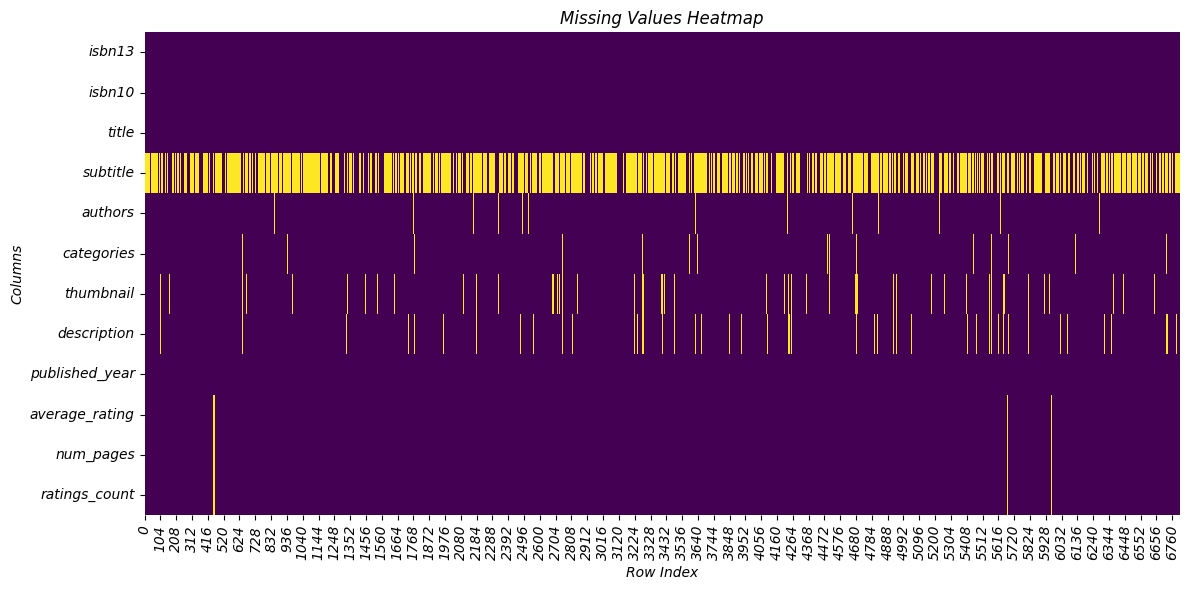

In [11]:
# 4. Missing Values Heatmap (like in the video)
plt.figure(figsize=(12, 6))
sns.heatmap(books.isna().transpose(), 
            cbar=False, 
            yticklabels=True,
            cmap='viridis')
plt.xlabel("Row Index")
plt.ylabel("Columns")
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

### Missing Data Analysis 
- **Subtitle**: 65% missing - not usable as standalone feature
- **Description**: 3.85% missing (262 books) - critical for semantic search
- **Rating fields**: 43 books missing all three (average_rating, num_pages, ratings_count) - likely from different data source
- **Published year**: Minimal missing (0.09%)
- Pattern: Missing rating fields cluster together, suggesting data source mismatch

In [12]:
# 5. Basic Statistics for Numeric Columns
print("=" * 60)
print("NUMERIC COLUMNS SUMMARY")
print("=" * 60)
print(books.describe())

NUMERIC COLUMNS SUMMARY
             isbn13  published_year  average_rating    num_pages  \
count  6.810000e+03     6804.000000     6767.000000  6767.000000   
mean   9.780677e+12     1998.630364        3.933284   348.181026   
std    6.068911e+08       10.484257        0.331352   242.376783   
min    9.780002e+12     1853.000000        0.000000     0.000000   
25%    9.780330e+12     1996.000000        3.770000   208.000000   
50%    9.780553e+12     2002.000000        3.960000   304.000000   
75%    9.780810e+12     2005.000000        4.130000   420.000000   
max    9.789042e+12     2019.000000        5.000000  3342.000000   

       ratings_count  
count   6.767000e+03  
mean    2.106910e+04  
std     1.376207e+05  
min     0.000000e+00  
25%     1.590000e+02  
50%     1.018000e+03  
75%     5.992500e+03  
max     5.629932e+06  


In [13]:
# 6. Category Distribution (one of the key features they analyzed)
if 'categories' in books.columns:
    print("=" * 60)
    print("CATEGORY DISTRIBUTION")
    print("=" * 60)
    category_counts = books['categories'].value_counts()
    print(f"Total unique categories: {category_counts.nunique()}")
    print(f"\nTop 20 categories:")
    print(category_counts.head(20))
    print(f"\nCategories with only 1 book: {(category_counts == 1).sum()}")

CATEGORY DISTRIBUTION
Total unique categories: 47

Top 20 categories:
categories
Fiction                      2588
Juvenile Fiction              538
Biography & Autobiography     401
History                       264
Literary Criticism            166
Philosophy                    160
Comics & Graphic Novels       159
Religion                      137
Drama                         132
Juvenile Nonfiction           116
Poetry                         79
Science                        71
Literary Collections           71
Business & Economics           67
Social Science                 60
Performing Arts                50
Cooking                        47
Art                            46
Body, Mind & Spirit            44
Travel                         43
Name: count, dtype: int64

Categories with only 1 book: 390


### Category Distribution
- **47 unique categories** with highly uneven distribution
- Fiction dominates (38% of books)
- **390 categories have only 1 book** - long-tail problem
- **Decision**: Need normalization to 4 main categories (Fiction, Non-fiction, Children's Fiction, Children's Non-fiction)

In [14]:
# 7. Description Length Analysis
if 'description' in books.columns:
    print("=" * 60)
    print("DESCRIPTION QUALITY")
    print("=" * 60)
    books['description_word_count'] = books['description'].str.split().str.len()
    print(f"Descriptions with word count statistics:")
    print(books['description_word_count'].describe())
    print(f"\nDescriptions with < 25 words: {(books['description_word_count'] < 25).sum()}")
    print(f"Descriptions with missing values: {books['description'].isna().sum()}")

DESCRIPTION QUALITY
Descriptions with word count statistics:
count    6548.000000
mean       66.744044
std        66.688252
min         1.000000
25%        27.000000
50%        40.000000
75%        83.000000
max       920.000000
Name: description_word_count, dtype: float64

Descriptions with < 25 words: 1318
Descriptions with missing values: 262


### Description Quality
- Mean: 67 words, Median: 40 words
- **1,318 descriptions** (<25 words) are too short for meaningful semantic search
- **262 descriptions** are completely missing
- **Decision**: Filter out descriptions with <25 words

In [15]:
# 8. Check for Duplicate ISBNs
print("=" * 60)
print("DUPLICATE CHECK")
print("=" * 60)
# Check both ISBN columns if they exist
for col in ['isbn10', 'isbn13']:
    if col in books.columns:
        duplicates = books[col].duplicated().sum()
        print(f"{col}: {duplicates} duplicates")
        if duplicates > 0:
            print(f"  Sample duplicates: {books[books[col].duplicated(keep=False)][col].head()}")

DUPLICATE CHECK
isbn10: 0 duplicates
isbn13: 0 duplicates



### Data Integrity 

No duplicate ISBNs found - data quality confirmed

### Cleaning Actions Required
1. Remove books with missing descriptions, pages, ratings, or published year (~303 books, 4.5%)
2. Filter descriptions shorter than 25 words (~1,318 books)
3. Expected final dataset: ~5,200 books with complete, meaningful descriptions

### Check for Bias in Missing Data

Before removing books with missing descriptions, we need to verify that missing descriptions are not correlated with other book characteristics. If strong correlations exist, removing these books could introduce bias (e.g., disproportionately removing older books if they're more likely to have missing descriptions).

This analysis checks correlations between missing descriptions and key variables (book age, page count, ratings) to ensure our cleaning decisions won't skew the dataset.

In [17]:
import numpy as np

books["missing_description"] = np.where(books["description"].isna(), 1, 0)
books["age_of_book"] = 2024 - books["published_year"]

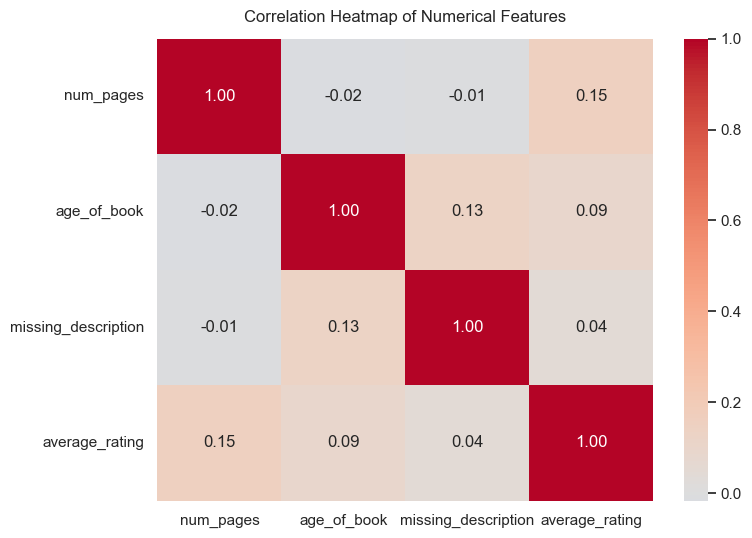

In [ ]:
columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]

correlation_matrix = books[columns_of_interest].corr(method = "spearman")

sns.set_theme(style = "white")
plt.figure(figsize = (8, 6))
heatmap = sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", center = 0)
heatmap.set_title("Correlation Heatmap of Numerical Features", fontdict = {"fontsize": 12}, pad = 12)

plt.show()

### Missing Data Action 1: Remove Books with Missing Critical Fields

**What we did:**
Filtered out books that have missing values in any of the critical fields: description, num_pages, average_rating, or published_year.

**Why:**
- Description is essential for semantic search and recommendations
- Rating fields (num_pages, average_rating, ratings_count) are needed for filtering and quality assessment
- Published year may be useful for temporal analysis
- These 43 books missing all three rating fields likely come from a different data source

**Impact:**
- Removed ~303 books (4.5% of dataset)
- Result: ~6,507 books remaining with complete critical fields
- No significant bias introduced (correlations with missing descriptions are weak: -0.01 to 0.13)

**Code logic:**
Kept only rows where all four fields are not missing using boolean filtering with `.notna()`.

In [22]:
books[(books["description"].isna()) |
    (books["num_pages"].isna()) |
    (books["average_rating"].isna()) |
    (books["published_year"].isna())
]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,description_word_count,missing_description,age_of_book
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0,NaN,1,24.0
60,9780007127740,000712774X,The illustrated man,NaN,Ray Bradbury,Fiction,http://books.google.com/books/content?id=kePql...,NaN,2002.0,4.14,186.0,56781.0,NaN,1,22.0
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,Clive Staples Lewis,Fairy tales,NaN,NaN,1978.0,4.26,1425.0,1446.0,NaN,1,46.0
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,Georg Wilhelm Friedrich Hegel,Philosophy,http://books.google.com/books/content?id=BCvcY...,NaN,1953.0,3.64,95.0,430.0,NaN,1,71.0
105,9780026995016,0026995018,Spandau,The Secret Diaries,Albert Speer,History,NaN,NaN,1976.0,4.12,463.0,6.0,NaN,1,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,Nick Hornby,NaN,http://books.google.com/books/content?id=PuDYw...,NaN,2002.0,3.80,256.0,155.0,NaN,1,22.0
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,Shiro Kobayashi;Helmut Ritter;David Kaplan,Science,http://books.google.com/books/content?id=WXOym...,NaN,2006.0,0.00,254.0,0.0,NaN,1,18.0
6798,9787506435673,7506435675,Good Fight,NaN,Judd Winick;Matthew Clark,Juvenile Fiction,http://books.google.com/books/content?id=xGPZA...,Presents the adventures of a new group of hero...,2007.0,NaN,NaN,NaN,33.0,0,17.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0,NaN,1,31.0


Given the size of our dataset, the number of missing values is well under 5% which leads to removing these values. 

In [26]:
books_clean = books[~(books["description"].isna()) &
                    ~(books["num_pages"].isna()) &
                    ~(books["average_rating"].isna()) &
                    ~(books["published_year"].isna())]

books_clean.head()


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,description_word_count,missing_description,age_of_book
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,199.0,0,20.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,205.0,0,24.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,14.0,0,42.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,57.0,0,31.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,45.0,0,22.0


### Missing Data Action 2: Analyze Category Distribution

**Problem:**
The dataset has over 500 unique categories, with many categories containing only 1-2 books. Removing 300 books with missing categories won't solve this long-tail problem.

**What we'll do:**
1. Count occurrences of each category
2. Sort categories by count in descending order
3. Visualize the distribution to identify the long-tail pattern

**Goal:**
Understand the category distribution to plan normalization strategy. We'll collapse categories into 4 main groups (Fiction, Non-fiction, Children's Fiction, Children's Non-fiction) in a later step using zero-shot classification.

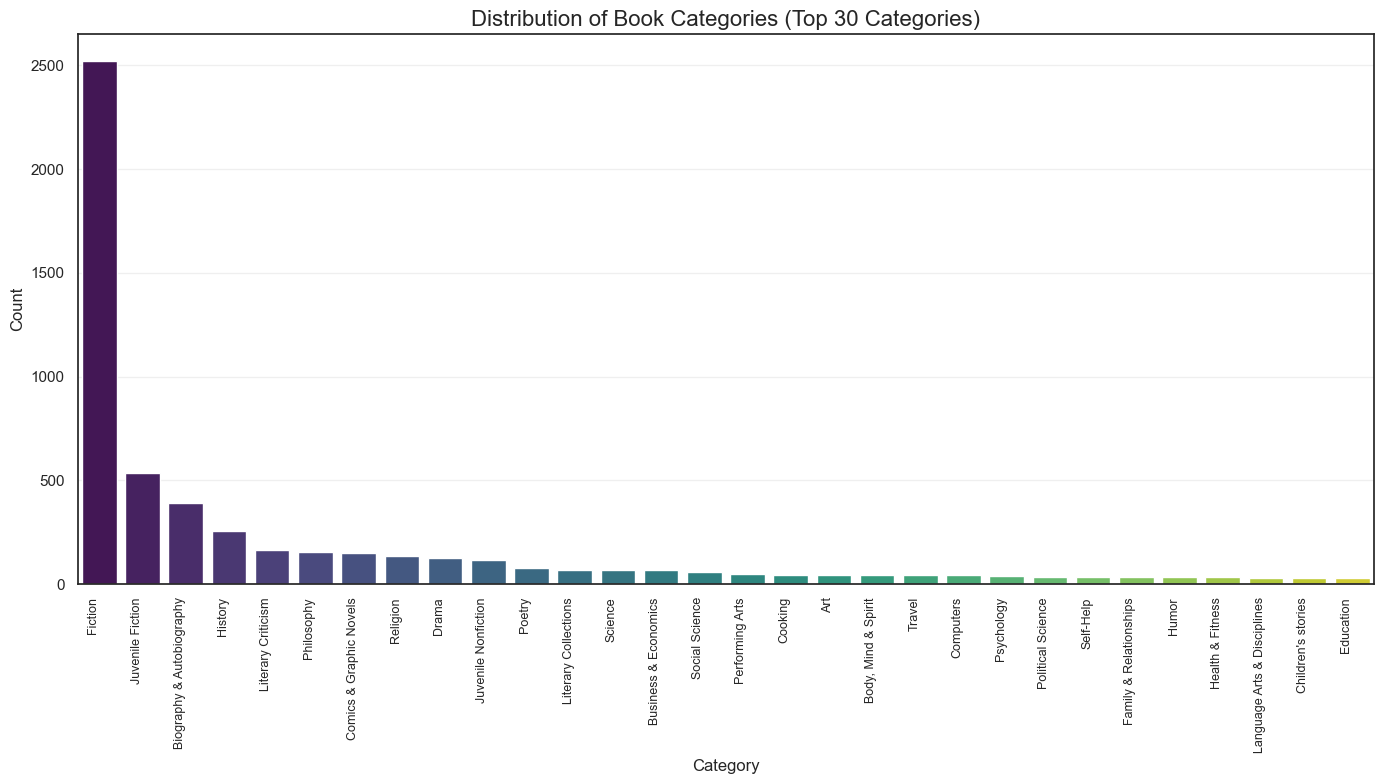


Total unique categories: 531
Top 30 categories account for: 5455 books (83.8%)
Categories with count > 50: 15
Categories with count = 1: 371

Top 10 categories:
categories
Fiction                      2523
Juvenile Fiction              534
Biography & Autobiography     391
History                       258
Literary Criticism            164
Philosophy                    154
Comics & Graphic Novels       152
Religion                      136
Drama                         126
Juvenile Nonfiction           114
Name: count, dtype: int64

Long-tail summary: 501 categories have fewer than 24 books


In [28]:
# Count categories and sort by count (descending)
category_counts = books_clean['categories'].value_counts().sort_values(ascending=False)

# Show top 30 categories for visualization
top_n = 30
top_categories = category_counts.head(top_n)

# Create visualization
plt.figure(figsize=(14, 8))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')

plt.title(f'Distribution of Book Categories (Top {top_n} Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal unique categories: {len(category_counts)}")
print(f"Top {top_n} categories account for: {top_categories.sum()} books ({top_categories.sum()/len(books_clean)*100:.1f}%)")
print(f"Categories with count > 50: {(category_counts > 50).sum()}")
print(f"Categories with count = 1: {(category_counts == 1).sum()}")
print(f"\nTop 10 categories:")
print(category_counts.head(10))
print(f"\nLong-tail summary: {len(category_counts) - top_n} categories have fewer than {category_counts.iloc[top_n]} books")

### Missing Data Action 3: Filter Short Descriptions

**Problem:**
Some descriptions are too short (e.g., "Donation.") and provide insufficient context for semantic search and meaningful recommendations.

**Approach:**
1. Calculate word count for each description
2. Visualize the distribution of word counts
3. Examine descriptions in custom bins (1-4 words, 5-14 words, 15-24 words) to determine minimum threshold
4. Set cutoff point at 25 words based on bin analysis
5. Filter out descriptions shorter than 25 words

**Goal:**
Create `books_clean_25_words` containing only books with descriptions of sufficient length for quality semantic search.

In [ ]:
# create a new column with the number of words in the description
books_clean["words_in_description"] = books_clean["description"].str.split().str.len()

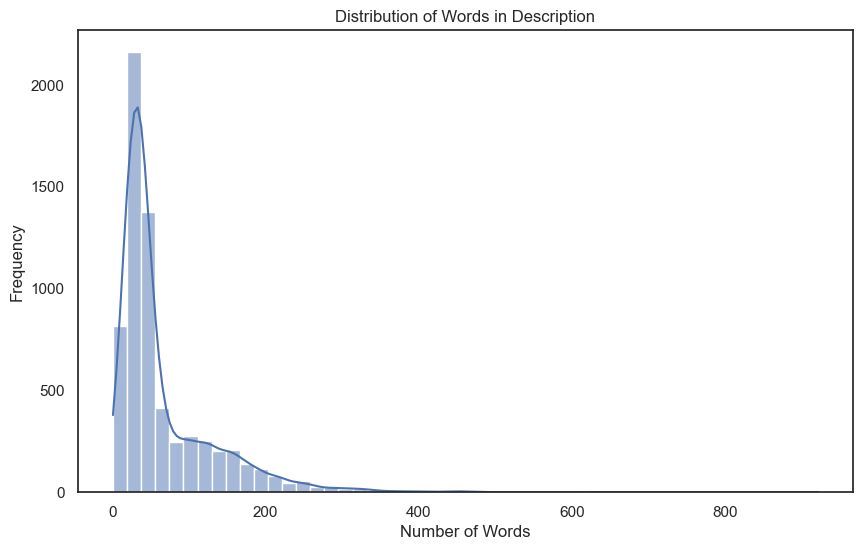

In [33]:
# create a histogram of the number of words in the description
plt.figure(figsize=(10, 6))
sns.histplot(books_clean["words_in_description"], bins=50, kde=True)
plt.title("Distribution of Words in Description")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [34]:
books_clean.loc[books_clean["words_in_description"].between(1, 4), "description"]

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1981                        

In [35]:
books_clean.loc[books_clean["words_in_description"].between(5, 14), "description"]

2       Volume Two of Stephen Donaldson's acclaimed se...
38      Koko is Peter Straub's foray into the psycholo...
70      A matter of life and death - and the Throne of...
77                         Nonsense rhyming story. 4 yrs+
84      A study guide for the novel There's a Boy in t...
                              ...                        
6715    The first comprehensive guide to addressing Na...
6726       Presents two complete novels from Henry James.
6757                          Audio Book- unabriged on CD
6776    Raymond Chandler meets The Exorcist. Classic n...
6795    Book Of Five Rings is a Kodansha International...
Name: description, Length: 308, dtype: object

In [37]:
books_clean.loc[books_clean["words_in_description"].between(15, 24), "description"]

10      One of Sidney Sheldon's most popular and bests...
32      Tells the story of three generations of Chines...
36      A magical and fantastic collection of early st...
57      A young drifter finds more than he bargained f...
68      A new 'The Doors of Perception' for the 21st c...
                              ...                        
6767    Everything from the fingerprints of the gods t...
6782    Displays one of America's leading physicist's ...
6783    Basics Illustration 01: Thinking Visually expl...
6789    Provides an introduction to the American artis...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 947, dtype: object

In [38]:
books_clean.loc[books_clean["words_in_description"].between(25, 34), "description"]

9       Kate Blackwell is an enigma and one of the mos...
14      Available in the U.S. for the first time, this...
20      It is 1937, and Charles Ashworth, a Canon to t...
21      Reissue of the author's most famous and well-l...
46      No one believes a little girl when she insists...
                              ...                        
6760    Joel, an English teacher, has never really lik...
6766    Discusses the historical and intellectual back...
6775    Presents nearly one thousand recipes--from app...
6779    Edited by the creator and executive producer o...
6799    This book is the story of a young girl obsesse...
Name: description, Length: 1229, dtype: object

In [40]:
books_clean_25_words = books_clean[books_clean["words_in_description"] >= 25]
books_clean_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,description_word_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,199.0,0,20.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,205.0,0,24.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,57.0,0,31.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,45.0,0,22.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,75.0,0,22.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,288.0,0,21.0,288
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,63.0,0,22.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,117.0,0,21.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,174.0,0,25.0,174


### Feature Engineering: Title and Subtitle

Combine title and subtitle into a single field for better display in the recommender. If subtitle is missing, use title only. If subtitle exists, combine them with a colon separator (e.g., "Title: Subtitle").

In [41]:
# Create title_and_subtitle column
# If subtitle is missing, use title only
# If subtitle exists, combine title + ": " + subtitle
books_clean_25_words["title_and_subtitle"] = np.where(
    books_clean_25_words["subtitle"].isna(),
    books_clean_25_words["title"].astype(str),
    books_clean_25_words["title"].astype(str) + ": " + books_clean_25_words["subtitle"].astype(str)
)

# Verify the result
print("✓ 'title_and_subtitle' column created")
print(f"\nSample entries:")
print(books_clean_25_words[["title", "subtitle", "title_and_subtitle"]].head(10))

✓ 'title_and_subtitle' column created

Sample entries:
                       title                                        subtitle  \
0                     Gilead                                             NaN   
1               Spider's Web                                         A Novel   
3             Rage of angels                                             NaN   
4             The Four Loves                                             NaN   
5        The Problem of Pain                                             NaN   
7     Empires of the Monsoon  A History of the Indian Ocean and Its Invaders   
8       The Gap Into Madness                                 Chaos and Order   
9         Master of the Game                                             NaN   
12       Warhost of Vastmark                                             NaN   
13  The Once and Future King                                             NaN   

                                   title_and_subtitle  
0       

### Feature Engineering: Tag Description

Prepend ISBN13 to each description for vector database linking. When semantic search returns descriptions, we can extract the ISBN from the front to efficiently map back to full book metadata (title, author, etc.) without string matching on full descriptions.

In [42]:
# Create tag_description: ISBN + description
# This allows us to extract ISBN from vector search results
books_clean_25_words["tag_description"] = (
    books_clean_25_words["isbn13"].astype(str) + " " + 
    books_clean_25_words["description"].astype(str)
)

# Verify the result
print("✓ 'tag_description' column created")
print(f"\nSample entries (showing first 100 chars):")
print(books_clean_25_words["tag_description"].str[:100].head())

✓ 'tag_description' column created

Sample entries (showing first 100 chars):
0    9780002005883 A NOVEL THAT READERS and critics...
1    9780002261982 A new 'Christie for Christmas' -...
3    9780006178736 A memorable, mesmerizing heroine...
4    9780006280897 Lewis' work on the nature of lov...
5    9780006280934 "In The Problem of Pain, C.S. Le...
Name: tag_description, dtype: object


In [43]:
# Drop temporary columns used for analysis/cleaning
columns_to_drop = ['subtitle', 'missing_description', 'age_of_book', 'description_word_count']

# Drop columns (only if they exist)
books_final = books_clean_25_words.drop(columns=[col for col in columns_to_drop if col in books_clean_25_words.columns])

# Save to CSV
output_path = DATA_DIR / 'books_cleaned.csv'
books_final.to_csv(output_path, index=False)

print(f"✓ Cleaned dataset saved to: {output_path}")
print(f"✓ Final dataset shape: {books_final.shape}")
print(f"✓ Columns remaining: {list(books_final.columns)}")

✓ Cleaned dataset saved to: ../data/books_cleaned.csv
✓ Final dataset shape: (5197, 14)
✓ Columns remaining: ['isbn13', 'isbn10', 'title', 'authors', 'categories', 'thumbnail', 'description', 'published_year', 'average_rating', 'num_pages', 'ratings_count', 'words_in_description', 'title_and_subtitle', 'tag_description']


## Phase 1 Complete: Data Cleaning Summary

**Output:** `books_cleaned.csv` with ~5,200 books

**Actions:** Removed missing critical fields, filtered short descriptions (<25 words), created `title_and_subtitle` and `tag_description` features.

**Ready for:** Phase 2 - Vector Search and embeddings